In [1]:
from graphviz import Digraph

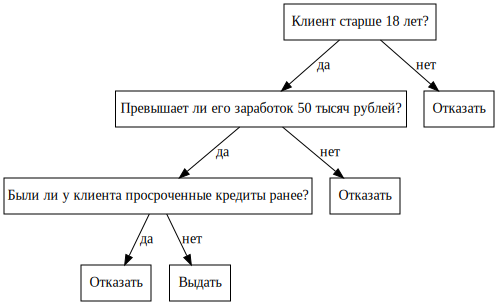

In [2]:
dot = Digraph(node_attr={'shape': 'box'})

dot.node('A', label='Клиент старше 18 лет?')
dot.node('B', label='Превышает ли его заработок 50 тысяч рублей?')
dot.node('C', label='Отказать')
dot.node('D', label='Были ли у клиента просроченные кредиты ранее?')
dot.node('E', label='Отказать')
dot.node('F', label='Отказать')
dot.node('G', label='Выдать')

dot.edge('A', 'B', label='да')
dot.edge('A', 'C', label='нет')
dot.edge('B', 'D', label='да')
dot.edge('B', 'E', label='нет')
dot.edge('D', 'F', label='да')
dot.edge('D', 'G', label='нет')

dot

In [3]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

import sys

In [4]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

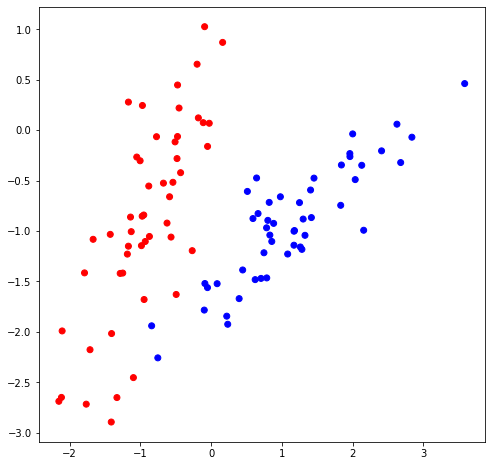

In [5]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле


In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

### Критерии разбиения Джини (был в методичке) и Энтропия

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества с критерием Джинни

def quality_gini(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Нахождение наилучшего разбиения с критерием Джинни

def find_best_split_gini(data, labels):
    
    #  обозначим минимальное количество объектов в узле

    min_leaf = 3

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_gini(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [28]:
# Расчет Энтропии

def entropii(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
         
    #  расчет критерия
    impurity = 0
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** np.log2(p)

    return impurity

In [29]:
# Расчет качества с Энтропией

def quality_entr(left_labels, right_labels, current_entropii):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropii - p * entropii(left_labels) - (1 - p) * entropii(right_labels)

In [30]:
# Нахождение наилучшего разбиения с Энтропией

def find_best_split_entr(data, labels):
    
    #  обозначим минимальное количество объектов в узле

    min_leaf = 3

    current_entropii = entropii(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_entr(true_labels, false_labels, current_entropii)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [31]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
          
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

### Реализация в данной функции критерия останова - глубина дерева

In [17]:
# Построение дерева с помощью рекурсивной функции. Критерий Джини


def build_tree_gini(data, labels, s):

    s1 = s
    
    while s1 != 0:
    

        quality_gini, t, index = find_best_split_gini(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality_gini == 0:
            return Leaf(data, labels)
        
        #Критерий останова(глубина)
        if s1 == 0:
            return LeafClassifier(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree_gini(true_data, true_labels, s)
        false_branch = build_tree_gini(false_data, false_labels, s)

        s1 -= 1

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    
        
    return Node(index, t, true_branch, false_branch)

In [32]:
# Построение дерева с помощью рекурсивной функции. Критерий Энтропии


def build_tree_entr(data, labels, s):

    s1 = s
    
    while s1 != 0:
    

        quality_entr, t, index = find_best_split_entr(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if quality_entr == 0:
            return Leaf(data, labels)
        
        #Критерий останова(глубина)
        if s1 == 0:
            return LeafClassifier(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = build_tree_entr(true_data, true_labels, s)
        false_branch = build_tree_entr(false_data, false_labels, s)

        s1 -= 1

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    
        
    return Node(index, t, true_branch, false_branch)

In [33]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [34]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [35]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [21]:
# Построим дерево по обучающей выборке (критерий Джини)
# a = int(input('Введите максимальную глубину дерева: '))

my_tree = build_tree_gini(train_data, train_labels, 3)

In [36]:
# Построим дерево по обучающей выборке (Энтропия)
# a = int(input('Введите максимальную глубину дерева: '))

my_tree = build_tree_entr(train_data, train_labels, 3)

In [37]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.02676286201867817
--> True:
  Индекс 0
  Порог -0.11161924805848533
  --> True:
    Прогноз: 0
  --> False:
    Индекс 0
    Порог -0.08810642121316392
    --> True:
      Прогноз: 1
    --> False:
      Прогноз: 0
--> False:
  Прогноз: 1


In [38]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [39]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [40]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [41]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

94.28571428571428

In [42]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

96.66666666666667

### Вывод: 1. Качество классификации у построенного дерева с криетерием Джинни - 98.57 и 100.0 на обучающейся и тестовой выборка соответственно.
### 2. Качество классификации у построенного дерева с Энтропией - 94.28 и 96.66 на обучающейся и тестовой выборка соответственно. Видим очевидную разницу в пользу критерия Джинни. 
### 3. Также стоит отметить разницу в простроении графиков. Энтропийный критерий, возможно, даст выигрыш на достаточно большом объеме данных.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'Test accuracy=96.67')

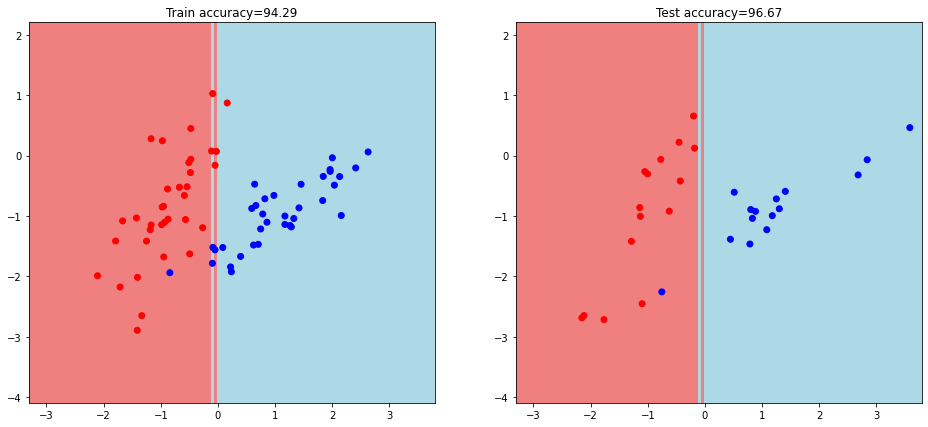

In [44]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')